## Prelimenary Setup

In [2]:
import os
import sys
import re
import numpy as np
import pandas as pd
import mne
from scipy.stats import wilcoxon
from scipy.stats import shapiro, ttest_rel
import itertools
mne.set_log_level('WARNING')


### Helper Functions

In [43]:
def load_data(file_path):
    return pd.read_csv(file_path)

def preprocess_data(data, columns_to_remove):
    columns_to_remove = [col.strip() for col in columns_to_remove if col.strip() in data.columns]
    data.drop(columns=columns_to_remove, inplace=True)
    return data

def extract_condition_columns(data, conditions):
    columns = data.columns
    condition_columns = {}
    for col in columns:
        for cond in conditions:
            if cond.lower() in col.lower():
                condition_columns.setdefault(cond, []).append(col)
                break
    return condition_columns

def extract_subject_ids(condition_columns):
    subject_ids = set()
    for cols in condition_columns.values():
        for col in cols:
            parts = col.split('_')
            subject_id = next((part for part in parts if part not in conditions), None)
            if subject_id:
                subject_ids.add(subject_id)
    return subject_ids

def create_long_format(data, subject_ids, conditions):
    long_format_dfs = []
    for condition in conditions:
        condition_lower = condition.lower()  # Convert the condition to lowercase
        for freq_band in data['FrequencyBand'].unique():
            band_data = data[data['FrequencyBand'] == freq_band]
            for subject_id in subject_ids:
                # Use case-insensitive matching for condition names
                subject_cols = [col for col in band_data.columns if subject_id in col and condition_lower in col.lower()]
                if subject_cols:
                    for col in subject_cols:
                        if len(band_data[col].values) > 0:
                            long_format_dfs.append({
                                'SubjectID': subject_id,
                                'Condition': condition,  # Keep the original case for the output
                                'FrequencyBand': freq_band,
                                'Value': band_data[col].values[0]
                            })
    return pd.DataFrame(long_format_dfs)

def test_normality(data, conditions, alpha=0.05, print_non_normal=True):
    normal_count = 0
    non_normal_count = 0
    non_normal_details = []

    for condition in conditions:
        for freq_band in data['FrequencyBand'].unique():
            subset = data[(data['Condition'] == condition) & (data['FrequencyBand'] == freq_band)]['Value']
            _, p = shapiro(subset)
            if p > alpha:
                normal_count += 1
            else:
                non_normal_count += 1
                non_normal_details.append((condition, freq_band, p))

    print(f'Number of tests indicating normal distribution: {normal_count}')
    print(f'Number of tests indicating non-normal distribution: {non_normal_count}')

    if print_non_normal and non_normal_count > 0:
        print("\nNon-normal distribution details (Condition, Frequency Band, p-value):")
        for detail in non_normal_details:
            print(detail)

def pairwise_comparison(data, conditions, subject_ids, alpha=0.05):
    comparison_results = []

    for condition_pair in itertools.combinations(conditions, 2):
        for freq_band in data['FrequencyBand'].unique():
            subjects_in_both = [s for s in subject_ids if s in data[(data['Condition'] == condition_pair[0]) & (data['FrequencyBand'] == freq_band)]['SubjectID'].values and 
                                                            s in data[(data['Condition'] == condition_pair[1]) & (data['FrequencyBand'] == freq_band)]['SubjectID'].values]
            number_of_subjects = len(subjects_in_both)  # Number of subjects used in this comparison
            values_condition1 = data[(data['SubjectID'].isin(subjects_in_both)) & (data['Condition'] == condition_pair[0]) & (data['FrequencyBand'] == freq_band)]['Value']
            values_condition2 = data[(data['SubjectID'].isin(subjects_in_both)) & (data['Condition'] == condition_pair[1]) & (data['FrequencyBand'] == freq_band)]['Value']
            
            if len(values_condition1) >= 3 and len(values_condition2) >= 3:
                _, p_normal_1 = shapiro(values_condition1)
                _, p_normal_2 = shapiro(values_condition2)

                if p_normal_1 > alpha and p_normal_2 > alpha:
                    stat, p = ttest_rel(values_condition1, values_condition2)
                    test_type = 'Parametric (t-test)'
                else:
                    stat, p = wilcoxon(values_condition1, values_condition2)
                    test_type = 'Non-Parametric (Wilcoxon)'
            elif len(values_condition1) > 1 and len(values_condition2) > 1:
                try:
                    stat, p = wilcoxon(values_condition1, values_condition2)
                    test_type = 'Non-Parametric (Wilcoxon)'
                except ValueError:
                    continue
            else:
                continue

            significance = "Yes" if p < alpha else "No"
            comparison_results.append({
                'Condition Pair': f'{condition_pair[0]} vs {condition_pair[1]}',
                'Frequency Band': freq_band,
                'Sample': number_of_subjects,
                'Statistic': f'{stat:.3f}',
                'P-Value': f'{p:.3f}',
                'Significant': significance,
                'Test Type': test_type
            })

    results_df = pd.DataFrame(comparison_results)
    return results_df

conditions = ["Pre", "Med1", "Med2", "Med3"]


### Modularity

In [44]:
file_path = "G:\\IMAGINE Analysis\\combined_results\\combined_avg_Modularity.csv"

data = load_data(file_path)
data = preprocess_data(data, columns_to_remove="Med2_4005")
condition_columns = extract_condition_columns(data, conditions)
subject_ids = extract_subject_ids(condition_columns)
long_format_data = create_long_format(data, subject_ids, conditions)
results_table = pairwise_comparison(long_format_data, conditions, subject_ids)
print(results_table)

# Save the results
output_file_path = "G:\\IMAGINE Analysis\\combined_results\\group_level_modularity.csv"
results_table.to_csv(output_file_path, index=False, mode='w')


   Condition Pair Frequency Band  Sample Statistic P-Value Significant  \
0     Pre vs Med1          Delta       4    -2.331   0.102          No   
1     Pre vs Med1          Theta       4    -1.269   0.294          No   
2     Pre vs Med1          Alpha       4    -0.638   0.569          No   
3     Pre vs Med1           Beta       4    -0.786   0.489          No   
4     Pre vs Med1          Gamma       4    -0.425   0.699          No   
5     Pre vs Med1        Average       4    -1.052   0.370          No   
6     Pre vs Med2          Delta       4     0.032   0.976          No   
7     Pre vs Med2          Theta       4     0.043   0.968          No   
8     Pre vs Med2          Alpha       4     0.581   0.602          No   
9     Pre vs Med2           Beta       4     5.000   1.000          No   
10    Pre vs Med2          Gamma       4    -0.168   0.877          No   
11    Pre vs Med2        Average       4     0.083   0.939          No   
12    Pre vs Med3          Delta      

### Shannon Entropy

In [45]:

file_path = "G:\\IMAGINE Analysis\\combined_results\\combined_avg_ShannonEntropy.csv"

data = load_data(file_path)
data = preprocess_data(data, columns_to_remove="MED2_4005")
condition_columns = extract_condition_columns(data, conditions)
subject_ids = extract_subject_ids(condition_columns)
long_format_data = create_long_format(data, subject_ids, conditions)
results_table = pairwise_comparison(long_format_data, conditions, subject_ids)
print(results_table)

# Save the results
output_file_path = "G:\\IMAGINE Analysis\\combined_results\\group_level_ShannonEntropy.csv"
results_table.to_csv(output_file_path, index=False, mode='w')


   Condition Pair Frequency Band  Sample Statistic P-Value Significant  \
0     Pre vs Med1          Delta       4    -0.424   0.700          No   
1     Pre vs Med1          Theta       4     4.000   0.875          No   
2     Pre vs Med1          Alpha       4     0.227   0.835          No   
3     Pre vs Med1           Beta       4     0.058   0.958          No   
4     Pre vs Med1          Gamma       4     5.000   1.000          No   
5     Pre vs Med1        Average       4    -0.124   0.909          No   
6     Pre vs Med2          Delta       4    -4.153   0.025         Yes   
7     Pre vs Med2          Theta       4    -4.857   0.017         Yes   
8     Pre vs Med2          Alpha       4   -14.529   0.001         Yes   
9     Pre vs Med2           Beta       4    -3.075   0.054          No   
10    Pre vs Med2          Gamma       4    -1.996   0.140          No   
11    Pre vs Med2        Average       4     0.000   0.125          No   
12    Pre vs Med3          Delta      

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


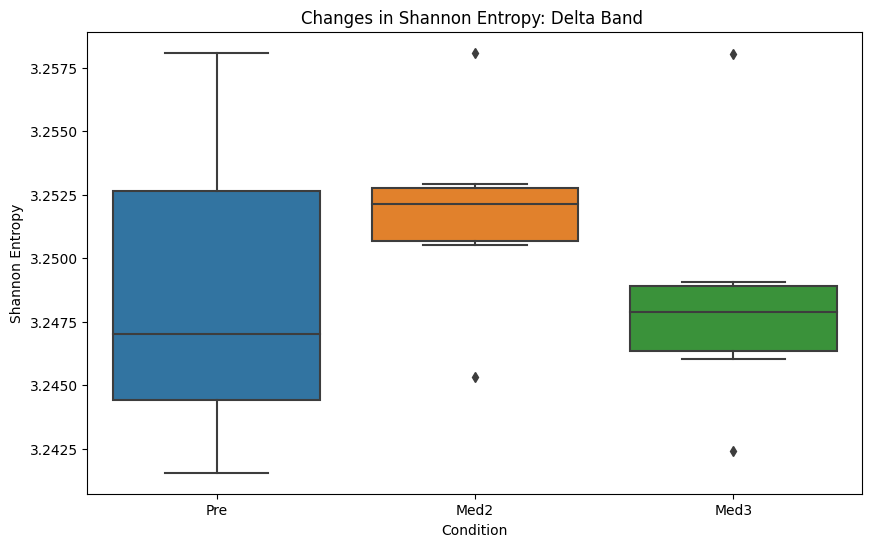

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


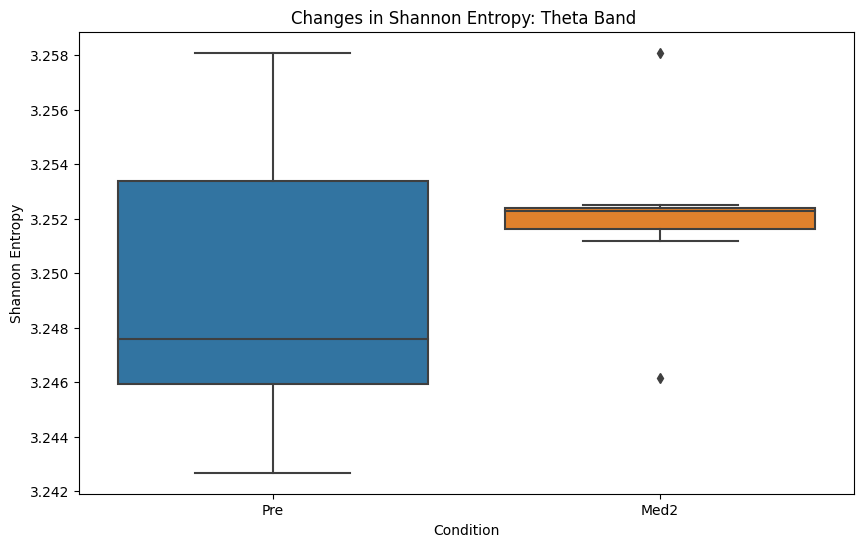

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


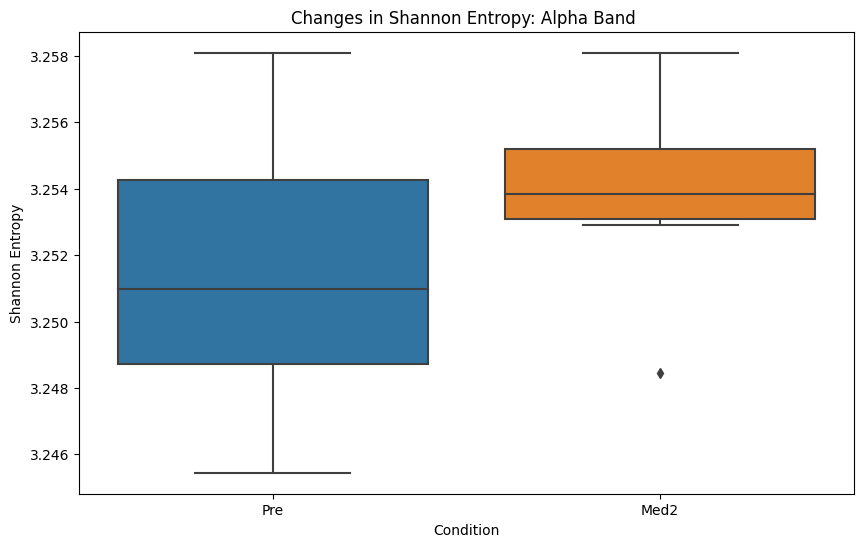

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Step 1: Filter Significant Results
significant_results = results_table[results_table['Significant'] == 'Yes']
filtered_data = pd.DataFrame()
for _, row in significant_results.iterrows():
    condition_pair = row['Condition Pair'].split(' vs ')
    freq_band = row['Frequency Band']
    
    temp_data = long_format_data[
        (long_format_data['FrequencyBand'] == freq_band) &
        (long_format_data['Condition'].isin(condition_pair))
    ]

    filtered_data = pd.concat([filtered_data, temp_data])

# Step 2: Plotting
default_condition_order = ['Pre', 'Med2', 'Med3']  # Default order
unique_freq_bands = filtered_data['FrequencyBand'].unique()

for freq_band in unique_freq_bands:
    plt.figure(figsize=(10, 6))
    
    # Filter data for current frequency band
    band_data = filtered_data[filtered_data['FrequencyBand'] == freq_band]
    
    # Update condition order based on the available data
    condition_order = [cond for cond in default_condition_order if cond in band_data['Condition'].unique()]
    
    # Proceed with plotting only if there are at least two conditions to compare
    if len(condition_order) > 1:
        sns.boxplot(x='Condition', y='Value', 
                    data=band_data,
                    order=condition_order)
        plt.title(f'Changes in Shannon Entropy: {freq_band} Band ')
        plt.ylabel('Shannon Entropy')
        plt.xlabel('Condition')
        plt.show()


In [48]:
unique_freq_bands

array(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Average'],
      dtype=object)

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


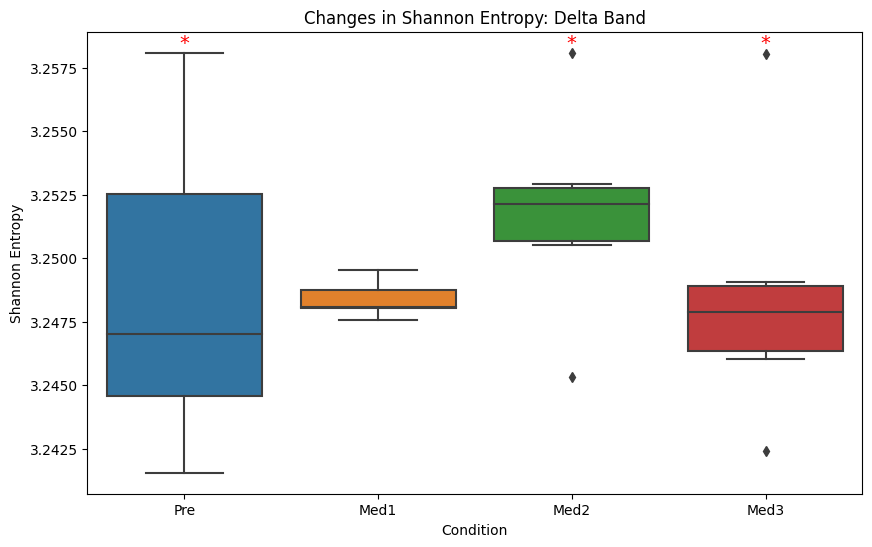

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


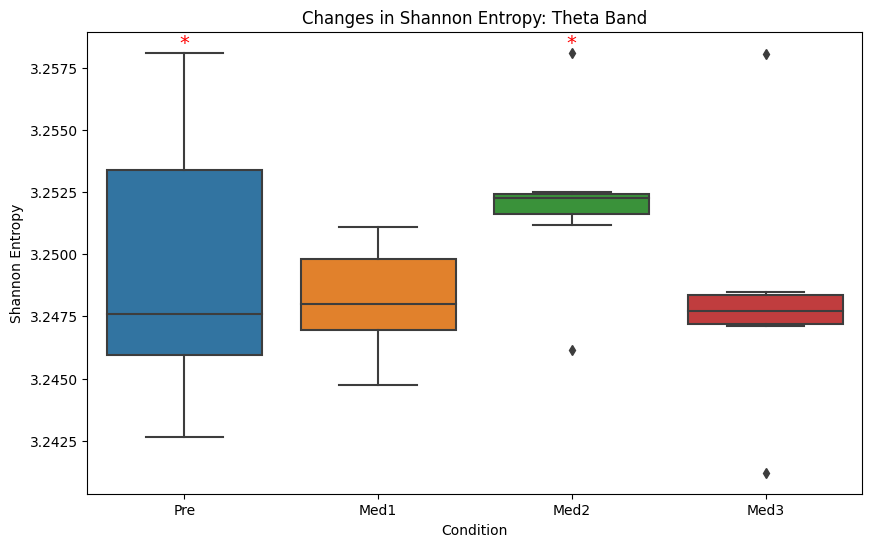

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


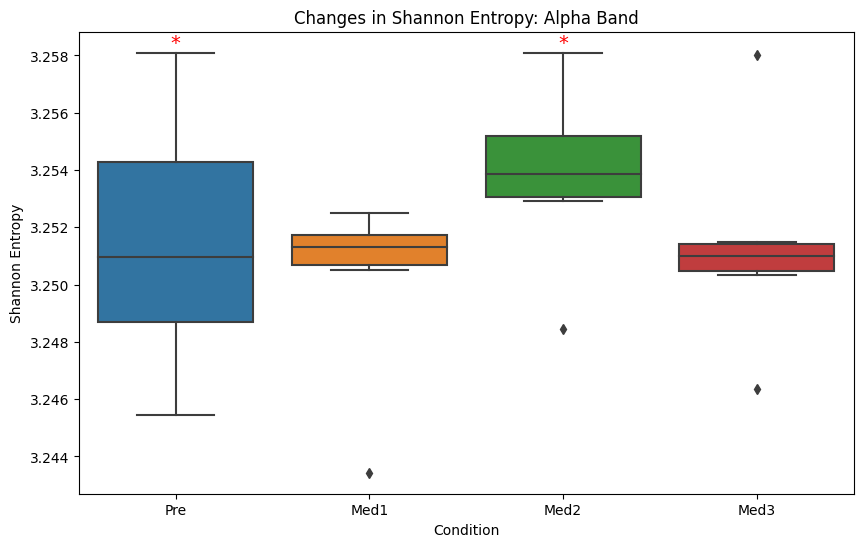

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


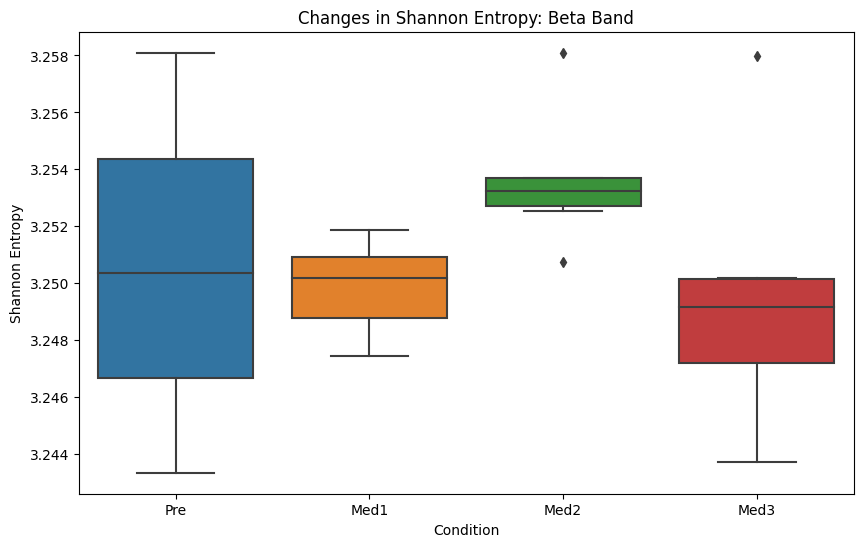

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


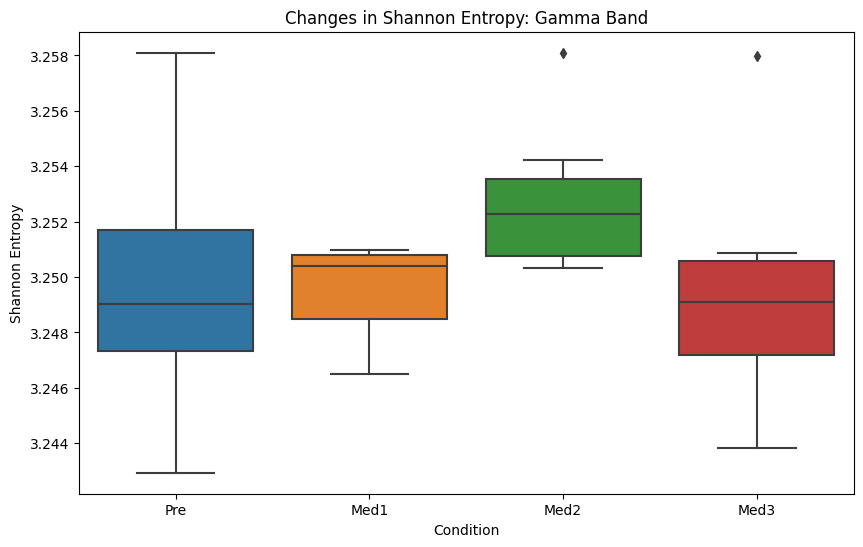

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


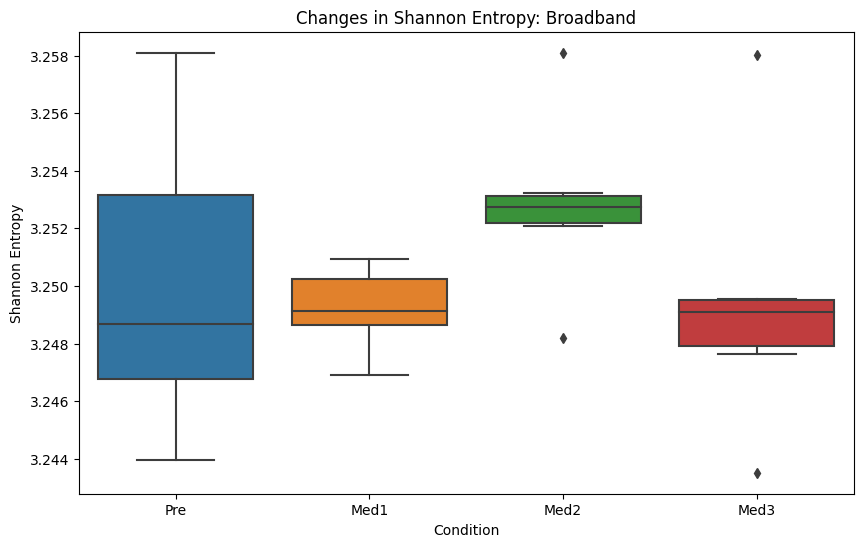

In [49]:
# Assuming long_format_data and results_table are defined as per your earlier code

# Step 1: Filter Significant Results
# Note: No need to filter the data this time; we will use all the data

# Step 2: Plotting
condition_order = ['Pre', 'Med1', 'Med2', 'Med3']  # Default order
unique_freq_bands = long_format_data['FrequencyBand'].unique()

for freq_band in unique_freq_bands:
    plt.figure(figsize=(10, 6))
    
    # Plot all data for current frequency band
    sns.boxplot(x='Condition', y='Value', 
                data=long_format_data[long_format_data['FrequencyBand'] == freq_band],
                order=condition_order)
    
    # Extract significant conditions for the current frequency band
    significant_conditions = results_table[
        (results_table['Significant'] == 'Yes') & 
        (results_table['Frequency Band'] == freq_band)
    ]['Condition Pair'].values
    
    # Add asterisks to significant conditions
    for index, condition in enumerate(condition_order):
        if any(condition in pair for pair in significant_conditions):
            # This condition is significant, mark it with an asterisk
            plt.text(index, long_format_data['Value'].max(), '*', ha='center', va='bottom', color='red', fontsize=14)
    
    # Conditional title change for 'Average' frequency band
    if freq_band == 'Average':
        plt.title('Changes in Shannon Entropy: Broadband')
    else:
        plt.title(f'Changes in Shannon Entropy: {freq_band} Band')
    
    plt.ylabel('Shannon Entropy')
    plt.xlabel('Condition')
    plt.show()


### PSD

In [53]:
import pandas as pd
import itertools
from scipy.stats import ttest_rel, shapiro

# Define channels for each brain region
brain_regions = {
    'Frontal': ['F1', 'F2', 'F7', 'F8', 'Fz'],
    'Central': ['C3', 'C4', 'Cz'],
    'Parietal': ['P3', 'P4', 'P7', 'P8', 'Pz'],
    'Occipital': ['O1', 'O2', 'Oz'],
    'Fronto-Central': ['FC3', 'FC4', 'FCz'],
    'Centro-Parietal': ['CP3', 'CP4', 'CPz'],
    'Parieto-Occipital': ['PO3', 'PO4', 'POz'],
    'Anterior Frontal': ['AFz']
}

# # Add the "Whole Brain" category
# all_channels = set(channel for region in brain_regions.values() for channel in region)
# brain_regions['Whole Brain'] = list(all_channels)

def reshape_data_to_long_format(data, conditions):
    condition_columns = {cond: [col for col in data.columns if cond in col] for cond in conditions}
    long_format_dfs = []

    for condition, cols in condition_columns.items():
        temp_df = data[['Channel', 'FrequencyBand'] + cols].melt(id_vars=['Channel', 'FrequencyBand'], 
                                                                 value_vars=cols, 
                                                                 var_name='Subject_Condition', 
                                                                 value_name='Value')
        temp_df['Condition'] = condition
        temp_df['Subject'] = temp_df['Subject_Condition'].apply(
            lambda x: next((part for part in x.split('_') if part not in conditions), None))
        temp_df.drop(columns=['Subject_Condition'], inplace=True)
        long_format_dfs.append(temp_df)

    return pd.concat(long_format_dfs)

# Function to calculate averages for each brain region
def calculate_region_averages(data, brain_regions):
    regional_data = []
    for region, channels in brain_regions.items():
        region_subset = data[data['Channel'].isin(channels)].copy()
        region_subset['Value'] = pd.to_numeric(region_subset['Value'], errors='coerce')
        region_subset.dropna(subset=['Value'], inplace=True)

        # Explicitly compute the mean using numpy
        averaged_data = region_subset.groupby(['Subject', 'Condition', 'FrequencyBand']).agg({'Value': lambda x: np.nanmean(x)}).reset_index()
        averaged_data['BrainRegion'] = region
        regional_data.append(averaged_data)
    return pd.concat(regional_data)

def pairwise_comparison(data, conditions, alpha=0.05, only_significant=True):
    comparison_results = []
    for region in data['BrainRegion'].unique():
        for condition_pair in itertools.combinations(conditions, 2):
            for freq_band in data['FrequencyBand'].unique():
                group1 = data[(data['BrainRegion'] == region) & 
                              (data['Condition'] == condition_pair[0]) & 
                              (data['FrequencyBand'] == freq_band)]
                group2 = data[(data['BrainRegion'] == region) & 
                              (data['Condition'] == condition_pair[1]) & 
                              (data['FrequencyBand'] == freq_band)]

                common_subjects = set(group1['Subject']).intersection(set(group2['Subject']))
                number_of_subjects = len(common_subjects)
                if number_of_subjects > 1:
                    filtered_group1 = group1[group1['Subject'].isin(common_subjects)]['Value']
                    filtered_group2 = group2[group2['Subject'].isin(common_subjects)]['Value']

                    # Apply the appropriate test based on the group size and normality
                    if len(filtered_group1) < 3 or len(filtered_group2) < 3:
                        test_type = 'Non-Parametric (Wilcoxon) - Small Sample'
                        try:
                            stat, p = wilcoxon(filtered_group1, filtered_group2)
                        except ValueError:  # In case Wilcoxon test is not applicable due to sample size or other issues
                            continue
                    else:
                        # Check for normality for larger groups
                        _, p_normal_1 = shapiro(filtered_group1)
                        _, p_normal_2 = shapiro(filtered_group2)

                        # Use t-test or Wilcoxon test based on normality
                        if p_normal_1 > alpha and p_normal_2 > alpha:
                            stat, p = ttest_rel(filtered_group1, filtered_group2)
                            test_type = 'Parametric (t-test)'
                        else:
                            stat, p = wilcoxon(filtered_group1, filtered_group2)
                            test_type = 'Non-Parametric (Wilcoxon)'

                    # Determine significance
                    significance = 'Yes' if p < alpha else 'No'

                    # Add results based on the `only_significant` flag
                    if not only_significant or (only_significant and p < alpha):
                        comparison_results.append({
                            'Brain Region': region,
                            'Condition Pair': f'{condition_pair[0]} vs {condition_pair[1]}',
                            'Frequency Band': freq_band,
                            
                            'Statistic': f'{stat:.3f}',
                            'P-Value': f'{p:.3f}',
                            'Test Type': test_type,
                            'Significance': significance,
                            'Sample': number_of_subjects
                        })

    return pd.DataFrame(comparison_results)

# Load data (example file path, replace with actual file path)
file_path = "G:\\IMAGINE Analysis\\combined_results\\combined_avg_psd.csv"
data = pd.read_csv(file_path)

# Define the conditions
conditions = ["Pre", "Med1", "Med2", "Med3"]

# Reshape the data to long format
long_format_data = reshape_data_to_long_format(data, conditions)

# Calculate averages for each brain region
region_averaged_data = calculate_region_averages(long_format_data, brain_regions)

# # Perform pairwise comparisons and display only significant results
significant_results_table = pairwise_comparison(region_averaged_data, conditions, only_significant=True)
print(significant_results_table)

# Specify the file path where the results will be saved
output_file_path = "G:\\IMAGINE Analysis\\combined_results\\group_level_psd (only significant).csv"
significant_results_table.to_csv(output_file_path, index=False, mode='w')


         Brain Region Condition Pair Frequency Band Statistic P-Value  \
0            Parietal    Pre vs Med2          Alpha     4.844   0.017   
1            Parietal    Pre vs Med2           Beta     5.141   0.014   
2            Parietal    Pre vs Med2          Gamma     4.113   0.026   
3            Parietal    Pre vs Med2          Theta     4.961   0.016   
4           Occipital    Pre vs Med2          Alpha     6.625   0.007   
5           Occipital    Pre vs Med2           Beta    11.247   0.002   
6           Occipital    Pre vs Med2          Gamma     6.070   0.009   
7           Occipital    Pre vs Med2          Theta     5.758   0.010   
8           Occipital    Pre vs Med3           Beta    -6.397   0.024   
9     Centro-Parietal    Pre vs Med2           Beta     5.280   0.013   
10    Centro-Parietal    Pre vs Med2          Gamma     5.391   0.013   
11    Centro-Parietal    Pre vs Med2          Theta     5.822   0.010   
12  Parieto-Occipital    Pre vs Med2          Alpha

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

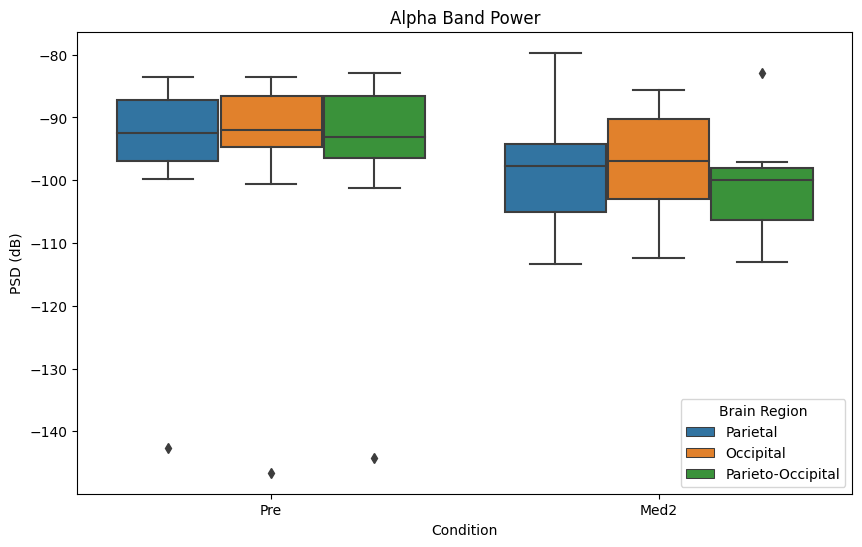

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

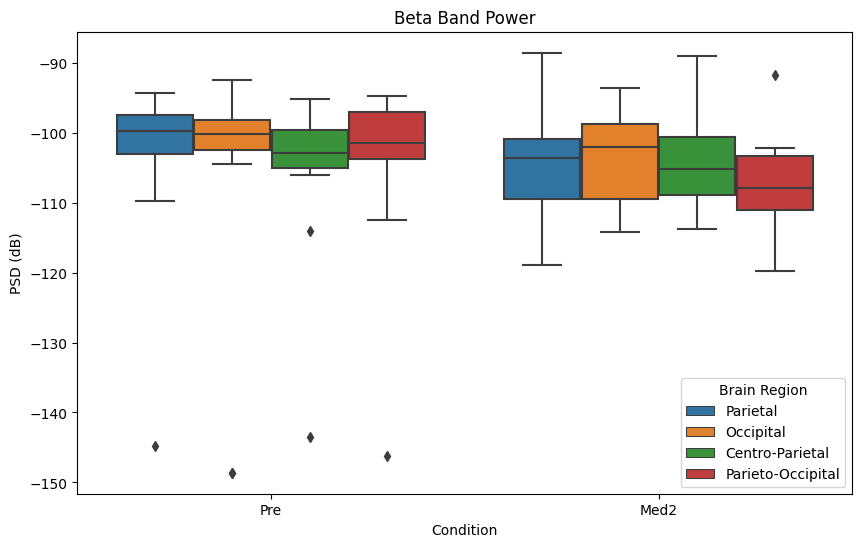

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

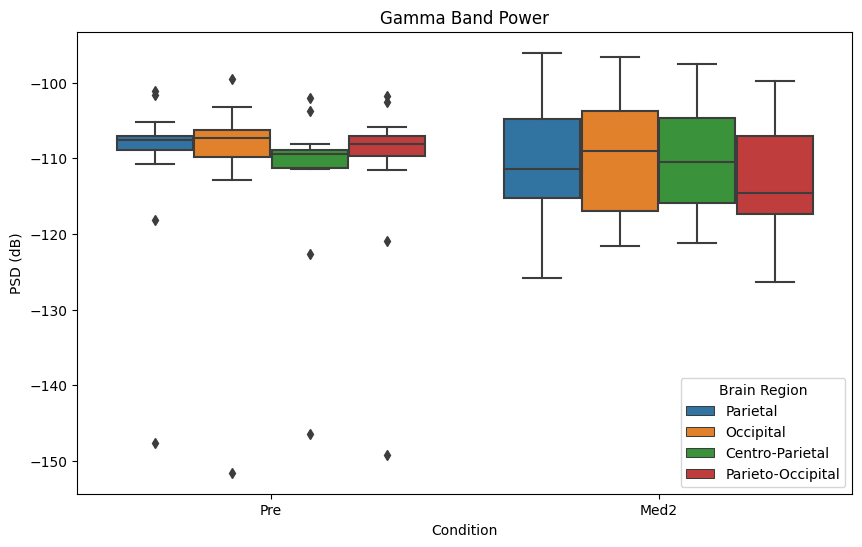

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

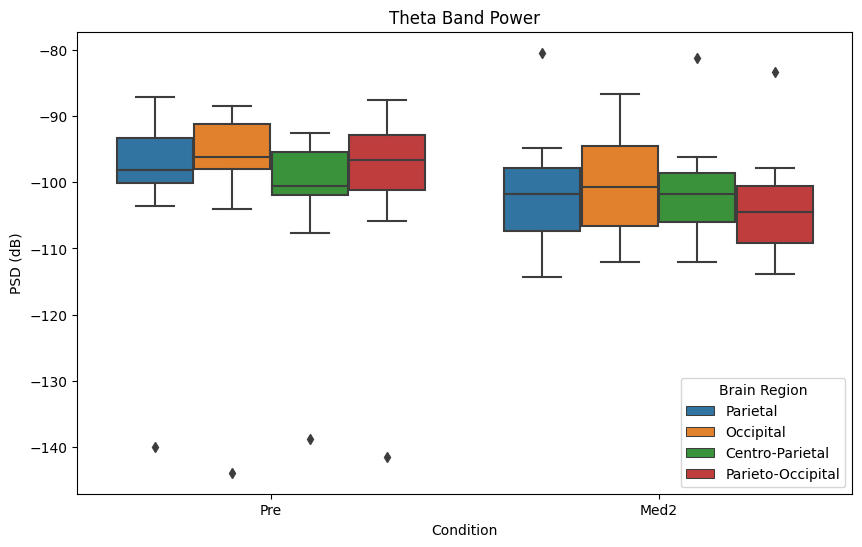

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

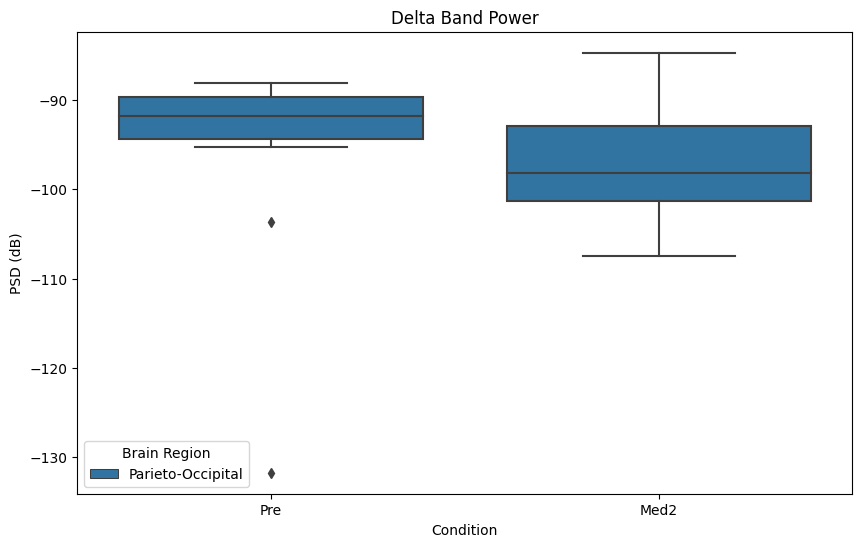

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data based on significant results
def filter_significant_data(region_averaged_data, significant_results_table):
    filtered_data = pd.DataFrame()
    for _, row in significant_results_table.iterrows():
        region = row['Brain Region']
        freq_band = row['Frequency Band']
        conditions = row['Condition Pair'].split(' vs ')

        temp_data = region_averaged_data[
            (region_averaged_data['BrainRegion'] == region) &
            (region_averaged_data['FrequencyBand'] == freq_band) &
            (region_averaged_data['Condition'].isin(conditions))
        ]

        filtered_data = pd.concat([filtered_data, temp_data])

    return filtered_data

# Filter the data
filtered_data = filter_significant_data(region_averaged_data, significant_results_table)

# Define the order of conditions, ensuring 'Pre' is first
condition_order = ['Pre', 'Med2']

# Create a box-whisker plot for each frequency band
unique_freq_bands = filtered_data['FrequencyBand'].unique()
for freq_band in unique_freq_bands:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Condition', y='Value', hue='BrainRegion', 
                data=filtered_data[filtered_data['FrequencyBand'] == freq_band],
                order=condition_order)  # Set the order of conditions
    plt.title(f'{freq_band} Band Power')
    plt.ylabel('PSD (dB)')
    plt.xlabel('Condition')
    plt.legend(title='Brain Region')
    plt.show()


C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

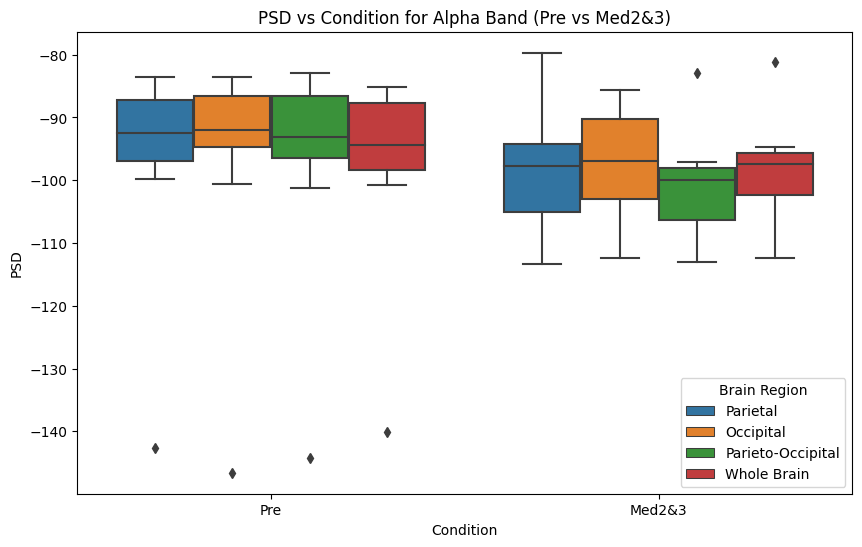

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

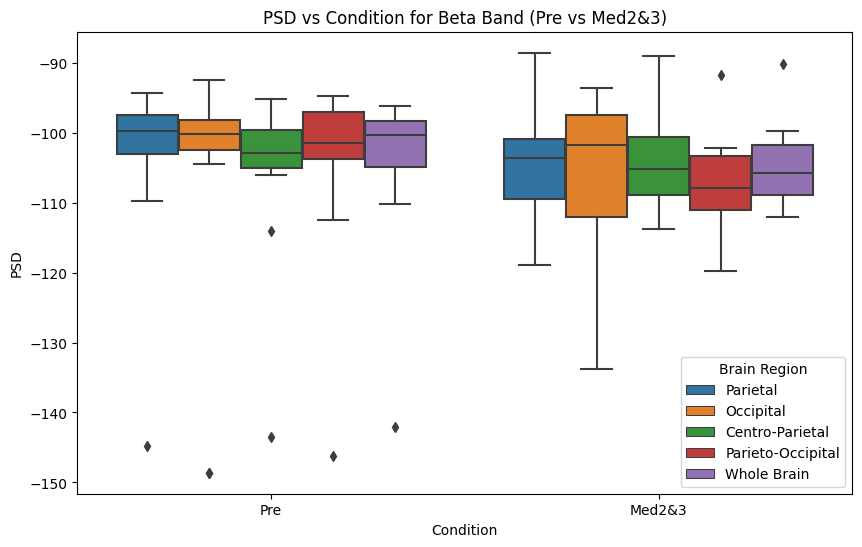

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

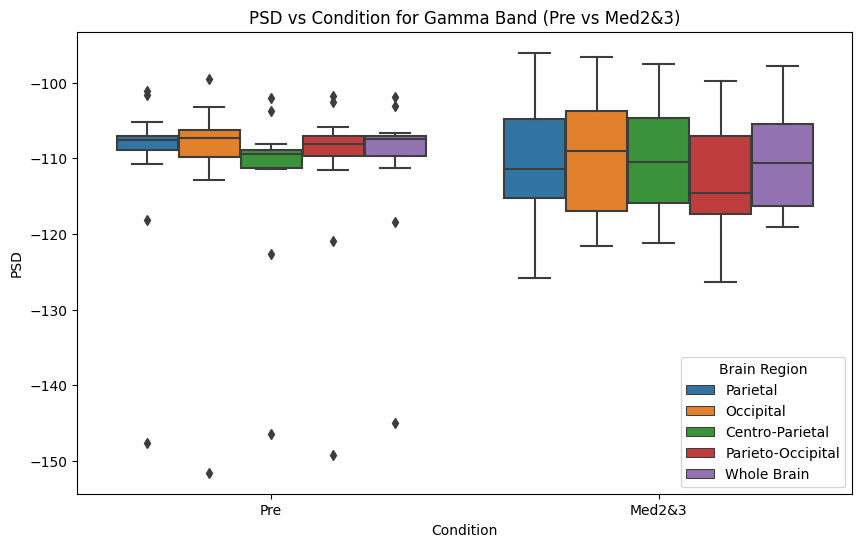

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

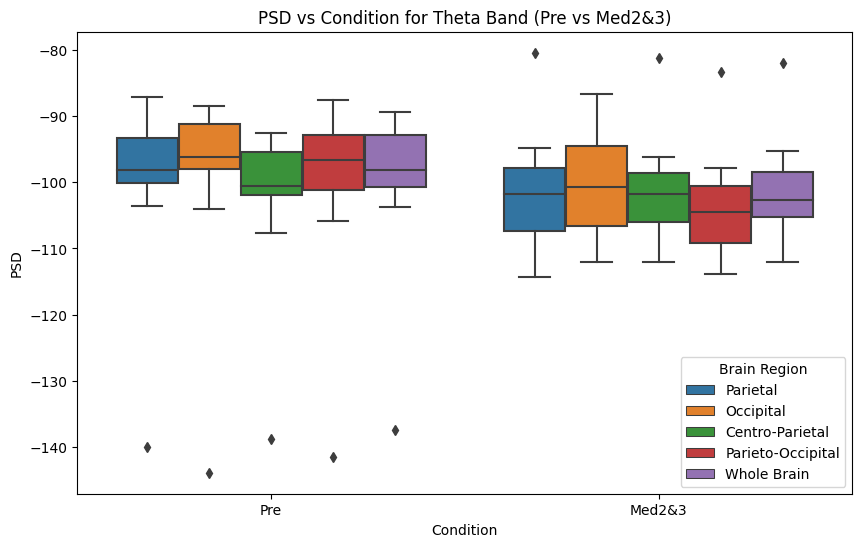

C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

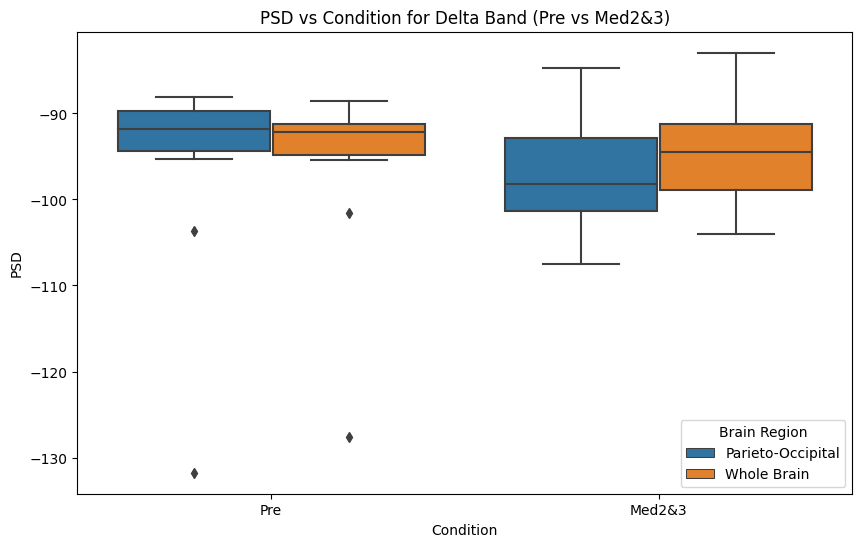

In [206]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming region_averaged_data and significant_results_table are already defined and available

# Function to filter the data
def filter_significant_data(region_averaged_data, significant_results_table):
    filtered_data = pd.DataFrame()
    for _, row in significant_results_table.iterrows():
        region = row['Brain Region']
        freq_band = row['Frequency Band']
        conditions = row['Condition Pair'].split(' vs ')

        temp_data = region_averaged_data[
            (region_averaged_data['BrainRegion'] == region) &
            (region_averaged_data['FrequencyBand'] == freq_band) &
            (region_averaged_data['Condition'].isin(conditions))
        ]

        filtered_data = pd.concat([filtered_data, temp_data])

    return filtered_data

# Filter the data
filtered_data = filter_significant_data(region_averaged_data, significant_results_table)

# Combine 'Med2' and 'Med3' into one category
filtered_data['Condition_Combined'] = filtered_data['Condition'].replace({'Med2': 'Med2&3', 'Med3': 'Med2&3'})

# Define the order of conditions, 'Pre' and combined 'Med2&3'
condition_order = ['Pre', 'Med2&3']

# Create a box-whisker plot for each frequency band
unique_freq_bands = filtered_data['FrequencyBand'].unique()
for freq_band in unique_freq_bands:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Condition_Combined', y='Value', hue='BrainRegion', 
                data=filtered_data[filtered_data['FrequencyBand'] == freq_band],
                order=condition_order)
    plt.title(f'PSD vs Condition for {freq_band} Band (Pre vs Med2&3)')
    plt.ylabel('PSD')
    plt.xlabel('Condition')
    plt.legend(title='Brain Region')
    plt.show()


#### Subject vs Condition Table

In [5]:
# Create a table with subject IDs and the meditation sessions they participated in
subject_sessions = long_format_data.groupby('Subject')['Condition'].unique().reset_index()

# Converting the array of sessions into a string for easier viewing
subject_sessions['Condition'] = subject_sessions['Condition'].apply(lambda x: ', '.join(x))

print(subject_sessions)


   Subject  Condition
0     1580  Pre, Med2
1     1960       Med3
2     2119        Pre
3      213        Pre
4      214        Pre
5   220427       Med1
6     4002       Med2
7     4005  Pre, Med2
8     4010       Med3
9     4015  Pre, Med1
10    4016       Med2
11    4018       Med1
12    4019  Pre, Med1
13    4020  Pre, Med3
14    4021       Med2
15    4022  Pre, Med1
16    4023  Pre, Med3
17    4025  Pre, Med2
18    4026  Pre, Med3
19    4027  Pre, Med2
20    4099  Pre, Med1
21    4119       Med3


### HFD

In [192]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import ttest_rel, shapiro, wilcoxon

# Load HFD data
file_path = "G:\\IMAGINE Analysis\\combined_results\\combined_avg_HFD.csv"
data = pd.read_csv(file_path)

# Reshape the data to long format without frequency band
def reshape_data_to_long_format_hfd_sampen(data, conditions):
    condition_columns = {cond: [col for col in data.columns if cond in col] for cond in conditions}
    long_format_dfs = []

    for condition, cols in condition_columns.items():
        temp_df = data[['Channel'] + cols].melt(id_vars=['Channel'], 
                                                value_vars=cols, 
                                                var_name='Subject_Condition', 
                                                value_name='Value')
        temp_df['Condition'] = condition
        temp_df['Subject'] = temp_df['Subject_Condition'].apply(
            lambda x: next((part for part in x.split('_') if part not in conditions), None))
        temp_df.drop(columns=['Subject_Condition'], inplace=True)
        long_format_dfs.append(temp_df)

    return pd.concat(long_format_dfs)

def test_normality_hfd_sampen(data, alpha=0.05):
    normal_count, non_normal_count = 0, 0
    for region in data['BrainRegion'].unique():
        for condition in data['Condition'].unique():
            subset = data[(data['BrainRegion'] == region) & 
                          (data['Condition'] == condition)]['Value']
            _, p = shapiro(subset)
            if p > alpha:
                normal_count += 1
            else:
                non_normal_count += 1
    print(f'Normal distribution: {normal_count}, Non-normal distribution: {non_normal_count}')

# Calculate averages for each brain region without frequency band
def calculate_region_averages_hfd_sampen(data, brain_regions):
    regional_data = []
    for region, channels in brain_regions.items():
        region_subset = data[data['Channel'].isin(channels)].copy()
        region_subset['Value'] = pd.to_numeric(region_subset['Value'], errors='coerce')
        region_subset.dropna(subset=['Value'], inplace=True)

        averaged_data = region_subset.groupby(['Subject', 'Condition']).agg({'Value': np.nanmean}).reset_index()
        averaged_data['BrainRegion'] = region
        regional_data.append(averaged_data)
    return pd.concat(regional_data)

def pairwise_comparison_hfd_sampen(data, conditions, alpha=0.05):
    comparison_results = []
    for region in data['BrainRegion'].unique():
        for condition_pair in itertools.combinations(conditions, 2):
            group1 = data[(data['BrainRegion'] == region) & 
                          (data['Condition'] == condition_pair[0])]
            group2 = data[(data['BrainRegion'] == region) & 
                          (data['Condition'] == condition_pair[1])]

            common_subjects = set(group1['Subject']).intersection(set(group2['Subject']))
            number_of_subjects = len(common_subjects)
            if number_of_subjects > 1:
                filtered_group1 = group1[group1['Subject'].isin(common_subjects)]['Value']
                filtered_group2 = group2[group2['Subject'].isin(common_subjects)]['Value']

                # Apply the appropriate test based on the group size and normality
                if len(filtered_group1) < 3 or len(filtered_group2) < 3:
                    test_type = 'Non-Parametric (Wilcoxon) - Small Sample'
                    try:
                        stat, p = wilcoxon(filtered_group1, filtered_group2)
                    except ValueError:  # In case Wilcoxon test is not applicable due to sample size or other issues
                        continue
                else:
                    _, p_normal_1 = shapiro(filtered_group1)
                    _, p_normal_2 = shapiro(filtered_group2)

                    if p_normal_1 > alpha and p_normal_2 > alpha:
                        stat, p = ttest_rel(filtered_group1, filtered_group2)
                        test_type = 'Parametric (t-test)'
                    else:
                        stat, p = wilcoxon(filtered_group1, filtered_group2)
                        test_type = 'Non-Parametric (Wilcoxon)'

                significance = 'Yes' if p < alpha else 'No'

                comparison_results.append({
                    'Brain Region': region,
                    'Condition Pair': f'{condition_pair[0]} vs {condition_pair[1]}',
                    'Statistic': f'{stat:.3f}',
                    'P-Value': f'{p:.3f}',
                    'Significance': significance,
                    'Test Type': test_type,
                    'Sample': number_of_subjects  # Include number of subjects
                })

    return pd.DataFrame(comparison_results)

# Define the conditions
conditions = ["Pre", "Med1", "Med2", "Med3"]

# Reshape the data to long format
long_format_data = reshape_data_to_long_format_hfd_sampen(data, conditions)

# Calculate averages for each brain region
region_averaged_data = calculate_region_averages_hfd_sampen(long_format_data, brain_regions)

# Pairwise comparisons
significant_results_table = pairwise_comparison_hfd_sampen(region_averaged_data, conditions)
print(significant_results_table)

# Save the results
output_file_path = "G:\\IMAGINE Analysis\\combined_results\\group_level_HFD.csv"
significant_results_table.to_csv(output_file_path, index=False, mode='w')


         Brain Region Condition Pair Statistic P-Value Significance  \
0             Frontal    Pre vs Med1     1.847   0.162           No   
1             Frontal    Pre vs Med2     0.894   0.437           No   
2             Frontal    Pre vs Med3     1.000   0.500           No   
3             Central    Pre vs Med1     1.429   0.248           No   
4             Central    Pre vs Med2     3.000   0.625           No   
5             Central    Pre vs Med3     0.498   0.668           No   
6            Parietal    Pre vs Med1     1.134   0.339           No   
7            Parietal    Pre vs Med2    -0.450   0.683           No   
8            Parietal    Pre vs Med3    -0.070   0.950           No   
9           Occipital    Pre vs Med1     3.000   0.625           No   
10          Occipital    Pre vs Med2    -0.337   0.759           No   
11          Occipital    Pre vs Med3     3.000   1.000           No   
12     Fronto-Central    Pre vs Med1     1.318   0.279           No   
13    

C:\Users\ra\AppData\Local\Temp\ipykernel_33744\66169736.py:49: FutureWarning: The provided callable <function nanmean at 0x000001F0FEAC20C0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  averaged_data = region_subset.groupby(['Subject', 'Condition']).agg({'Value': np.nanmean}).reset_index()
C:\Users\ra\AppData\Local\Temp\ipykernel_33744\66169736.py:49: FutureWarning: The provided callable <function nanmean at 0x000001F0FEAC20C0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  averaged_data = region_subset.groupby(['Subject', 'Condition']).agg({'Value': np.nanmean}).reset_index()
C:\Users\ra\AppData\Local\Temp\ipykernel_33744\66169736.py:49: FutureWarning: The provided callable <function nanmean at 0x000001F0FEAC20C0> is currently using SeriesGroupBy.mean. In

### SampEn

In [198]:
# Load SampEn data
file_path = "G:\\IMAGINE Analysis\\combined_results\\combined_avg_SampleEntropy.csv"
data = pd.read_csv(file_path)

# Reshape the data to long format
long_format_data = reshape_data_to_long_format_hfd_sampen(data, conditions)

# Calculate averages for each brain region
region_averaged_data = calculate_region_averages_hfd_sampen(long_format_data, brain_regions)

# Pairwise comparisons
significant_results_table = pairwise_comparison_hfd_sampen(region_averaged_data, conditions)
print(significant_results_table)

# # Save the results
output_file_path = "G:\\IMAGINE Analysis\\combined_results\\group_level_SampleEntropy.csv"
significant_results_table.to_csv(output_file_path, index=False, mode='w')


         Brain Region Condition Pair Statistic P-Value Significance  \
0             Frontal    Pre vs Med1     2.000   0.375           No   
1             Frontal    Pre vs Med2     0.360   0.742           No   
2             Frontal    Pre vs Med3    -1.161   0.365           No   
3             Central    Pre vs Med1     0.000   0.125           No   
4             Central    Pre vs Med2     1.080   0.359           No   
5             Central    Pre vs Med3     0.923   0.453           No   
6            Parietal    Pre vs Med1     3.000   0.625           No   
7            Parietal    Pre vs Med2     0.759   0.503           No   
8            Parietal    Pre vs Med3    -0.061   0.957           No   
9           Occipital    Pre vs Med1     1.000   0.250           No   
10          Occipital    Pre vs Med2     0.663   0.555           No   
11          Occipital    Pre vs Med3    -0.123   0.913           No   
12     Fronto-Central    Pre vs Med1     1.000   0.250           No   
13    

C:\Users\ra\AppData\Local\Temp\ipykernel_33744\66169736.py:49: FutureWarning: The provided callable <function nanmean at 0x000001F0FEAC20C0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  averaged_data = region_subset.groupby(['Subject', 'Condition']).agg({'Value': np.nanmean}).reset_index()
C:\Users\ra\AppData\Local\Temp\ipykernel_33744\66169736.py:49: FutureWarning: The provided callable <function nanmean at 0x000001F0FEAC20C0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  averaged_data = region_subset.groupby(['Subject', 'Condition']).agg({'Value': np.nanmean}).reset_index()
C:\Users\ra\AppData\Local\Temp\ipykernel_33744\66169736.py:49: FutureWarning: The provided callable <function nanmean at 0x000001F0FEAC20C0> is currently using SeriesGroupBy.mean. In